In [436]:
# C:\Users\Joshoua\Pictures\Panasonic
# get 20 images from the above folder and convert them to greyscale, save them under the order they were processed in the png images folder
import os
import cv2
import random

def process_images(source_folder, destination_folder, num_images=20):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Initialize counter for naming images
    image_counter = 1

    # List to store file paths of images
    image_paths = []

    # Traverse through the source folder and its subfolders
    for root, dirs, files in os.walk(source_folder):
        for filename in files:
            # Check if the file is an image
            if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp')):
                image_paths.append(os.path.join(root, filename))

    # Shuffle the list of image paths
    random.shuffle(image_paths)

    # Process each image
    for image_path in image_paths[:num_images]:
        # Read the image
        image = cv2.imread(image_path)

        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Generate the destination file path
        destination_path = os.path.join(destination_folder, f"{image_counter}.png")

        # Write the grayscale image to the destination folder
        cv2.imwrite(destination_path, gray_image)

        # Increment the image counter
        image_counter += 1

        # Break if reached the desired number of images
        if image_counter > num_images:
            break

In [437]:
import numpy as np

# fet array of binary vectors from random patches of n*n pixels from images in the specified folder
def get_patterns_from_images(images_folder, patch_size, N_Patterns):
    binary_vectors = []

    # Get the list of images in the images folder
    image_files = os.listdir(images_folder)

    # Load all images into memory
    images = [cv2.imread(os.path.join(images_folder, image_file), cv2.IMREAD_GRAYSCALE) for image_file in image_files]

    for _ in range(N_Patterns):
        # Randomly select an image from the loaded images
        image = random.choice(images)

        # Get image dimensions
        height, width = image.shape

        # Randomly select the top-left corner of the patch
        start_x = random.randint(0, width - patch_size)
        start_y = random.randint(0, height - patch_size)

        # Extract the patch
        patch = image[start_y:start_y+patch_size, start_x:start_x+patch_size]

        # Convert each value in the patch to an 8-bit binary representation
        binary_patch = np.unpackbits(patch.astype(np.uint8))

        # Flatten the binary patch into a 1D array to create a binary vector
        binary_vector = binary_patch.flatten()

        # Store the binary vector in the list
        binary_vectors.append(binary_vector)

    return binary_vectors

In [438]:
def image_to_binary_vectors(image_path, patch_size):
    binary_vectors = []

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    height, width = image.shape

    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            # Extract the patch
            patch = image[y:y+patch_size, x:x+patch_size]

            # Convert pixel values to binary representation
            binary_patch = np.unpackbits(patch)

            # Append the binary patch to the list of binary vectors
            binary_vectors.append(binary_patch)

    return binary_vectors

In [439]:
def image_to_binary_vectors_overlap(image_path, patch_size, stride=1):
    binary_vectors = []

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    height, width = image.shape

    # Iterate over each row of patches with a given stride
    for y in range(0, height - patch_size + 1, stride):
        # Iterate over each column of patches with a given stride
        for x in range(0, width - patch_size + 1, stride):
            # Extract the patch
            patch = image[y:y+patch_size, x:x+patch_size]

            # Convert pixel values to binary representation
            binary_patch = np.unpackbits(patch)

            # Append the binary patch to the list of binary vectors
            binary_vectors.append(binary_patch)

    return binary_vectors


In [440]:
def create_image_from_patterns(width, height, patch_size, patterns, filename="input"):
    # Calculate the number of patches per row and column
    num_patches_x = width // patch_size
    num_patches_y = height // patch_size

    # Calculate the total number of patches
    total_patches = num_patches_x * num_patches_y

    # Check if the number of binary vectors matches the number of patches
    if len(patterns) != total_patches:
        print("Error: Number of binary vectors does not match the number of patches.")
        return None

    # Create an empty image
    image = np.zeros((height, width), dtype=np.uint8)

    # Iterate over each patch and fill it with the corresponding binary vector
    for i in range(num_patches_y):
        for j in range(num_patches_x):
            # Calculate the start and end indices for the binary vector
            pixelIndex = (i*num_patches_x) + j

            # Extract the binary vector for the patch
            patch_binary_vector = patterns[pixelIndex]

            # Reshape the binary vector to match the patch size
            patch_binary_vector = patch_binary_vector.reshape((patch_size*patch_size, 8))
            patch_binary_vector = np.packbits(patch_binary_vector)
            patch_binary_vector = patch_binary_vector.reshape((patch_size,patch_size))
            
            # Calculate the top-left corner coordinates of the patch
            x = j * patch_size
            y = i * patch_size

            # Fill the patch in the image with the binary values
            image[y:y+patch_size, x:x+patch_size] = patch_binary_vector

    # Show the image

    cv2.imwrite("./output/" + filename + ".png", image)
    
    return image


In [441]:
def multiply_edges(array, factor):
    # Create a mask for the edges of the array
    edge_mask = np.zeros_like(array, dtype=bool)
    edge_mask[0, :] = True  # Top edge
    edge_mask[-1, :] = True  # Bottom edge
    edge_mask[:, 0] = True  # Left edge
    edge_mask[:, -1] = True  # Right edge

    # Multiply the edge values by the factor
    array[edge_mask] *= factor

    return array

def create_image_from_patterns_v2(width, height, patch_size, patterns, filename="input", stride=1):

    # Calculate the total number of patches
    total_patches = width * height - width - height + 1

    # # Check if the number of binary vectors matches the number of patches
    # if len(patterns) != total_patches:
    #     print("Error: Number of binary vectors does not match the number of patches.")
    #     return None

    # Create an empty image
    image = np.zeros((height, width))

    # Iterate over each patch and fill it with the corresponding binary vector
    for i in range(width - patch_size + 1):
        for j in range(height - patch_size + 1):
            # Calculate the start and end indices for the binary vector
            pixelIndex = (i*(height - patch_size + 1)) + j

            # Extract the binary vector for the patch
            patch_binary_vector = patterns[pixelIndex]

            # Reshape the binary vector to match the patch size
            patch_binary_vector = patch_binary_vector.reshape((patch_size*patch_size, 8))
            patch_binary_vector = np.packbits(patch_binary_vector)
            patch_binary_vector = patch_binary_vector.reshape((patch_size,patch_size))
            
            # Calculate the top-left corner coordinates of the patch
            x = j
            y = i

            # Fill the patch in the image with the binary values
            image[y:y+patch_size, x:x+patch_size] += patch_binary_vector

    image = normalize(image) * 255

    cv2.imwrite("./output/" + filename + ".png", image)
    
    return image


In [442]:
def imprint_patterns(weightMatrix, patterns):
    n = len(weightMatrix)
    for p in range(len(patterns)):
        for i in range(n):
            for j in range(n):
                if i != j:
                    weightMatrix[i, j] += (2 / n) * (patterns[p][i] * 2 - 1) * (patterns[p][j] * 2 - 1)
    return weightMatrix

def predict(weightMatrix, patternArray, max_iterations=100):
    n = len(weightMatrix)
    predicted_patterns = []
    
    for input_pattern in patternArray:
        for _ in range(max_iterations):
            old_pattern = input_pattern.copy()
            for i in range(n):
                hi = np.dot(weightMatrix[i], input_pattern)
                input_pattern[i] = 0 if hi < 0 else 1  # Change thresholding here
            if np.array_equal(input_pattern, old_pattern):
                break
        predicted_patterns.append(input_pattern)
    return np.array(predicted_patterns)

In [443]:
import time

def procedure_loop(iterations, images_folder, patch_size, N_Patterns, max_iterations, input):

    images = []

    num_neurons = patch_size * patch_size * 8
    n = 0
    t = str(int(time.time())) 
    for _ in range(iterations):
        initial_weightMatrix = np.zeros((num_neurons, num_neurons))
        patterns = get_patterns_from_images(images_folder, patch_size, N_Patterns)
        weightMatrix = imprint_patterns(initial_weightMatrix, patterns)
        noisy_patterns = image_to_binary_vectors(input, patch_size)
        predicted_patterns = predict(weightMatrix, noisy_patterns, max_iterations)    
        n += 1
        filename = t + '_' + str(n) + '_' + str(patch_size) + '_' + str(N_Patterns) + '_' + str(max_iterations)
        reconstruction = create_image_from_patterns(256,256,patch_size,predicted_patterns, filename)
        images.append(reconstruction)

    return images, t

In [444]:
def procedure_loop_v2(iterations, images_folder, patch_size, N_Patterns, max_iterations, input):

    images = []

    num_neurons = patch_size * patch_size * 8
    n = 0
    t = str(int(time.time())) 
    noisy_patterns_original = image_to_binary_vectors_overlap(input, patch_size)
    for _ in range(iterations):
        initial_weightMatrix = np.zeros((num_neurons, num_neurons))
        patterns = get_patterns_from_images(images_folder, patch_size, N_Patterns)
        weightMatrix = imprint_patterns(initial_weightMatrix, patterns)
        noisy_patterns = np.array(noisy_patterns_original, copy=True)
        predicted_patterns = predict(weightMatrix, noisy_patterns, max_iterations)    
        n += 1
        filename = "img" + str(img_num) + '_' + t + '_' + str(n) + '_' + str(patch_size) + '_' + str(N_Patterns) + '_' + str(max_iterations)
        reconstruction = create_image_from_patterns_v2(256,256,patch_size,predicted_patterns, filename)
        images.append(reconstruction)

    return images, t

In [445]:
def standardize(array):
    mean = np.mean(array)
    std_dev = np.std(array)
    standardized_array = (array - mean) / std_dev
    return standardized_array, mean, std_dev

def reverse_standardize(standardized_array, mean, std_dev):
    original_array = standardized_array * std_dev + mean
    return original_array

def normalize(array):

    min = np.min(array)
    max = np.max(array)
    
    norm_array = (array - min) / (max - min)

    return norm_array

C:\Users\Joshoua\AppData\Local\Temp\ipykernel_8416\2888128483.py:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(1, 3, figsize=(15, 5))


KeyboardInterrupt: 

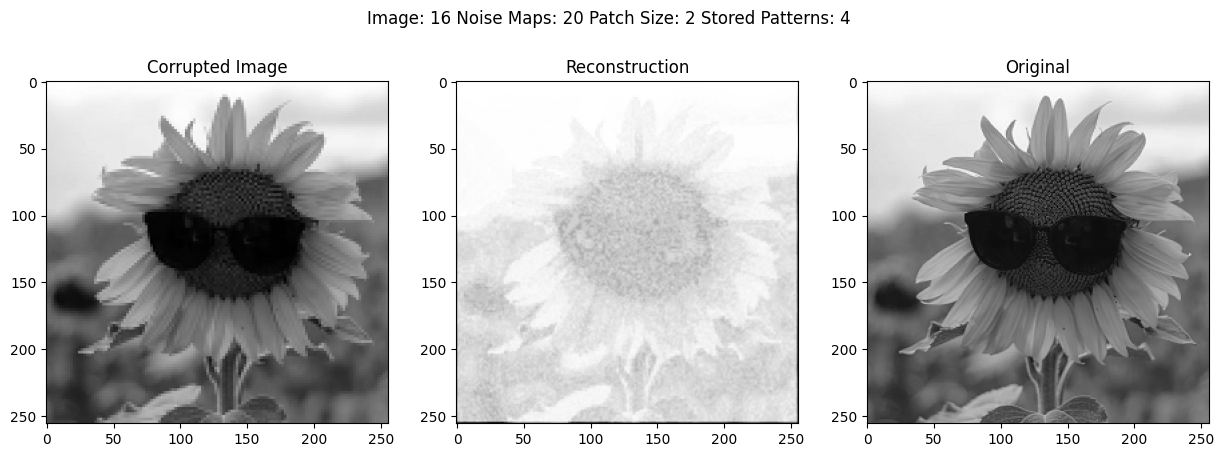

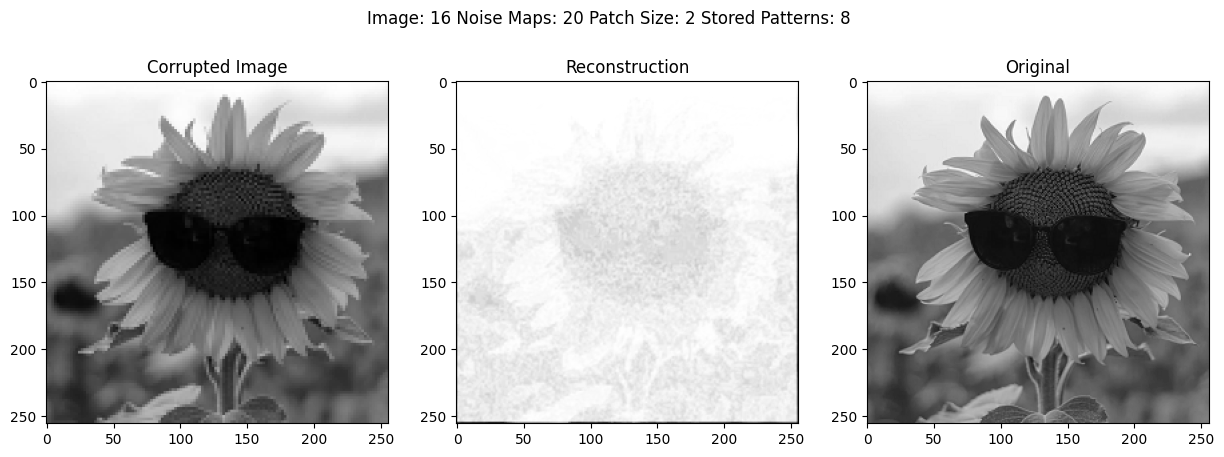

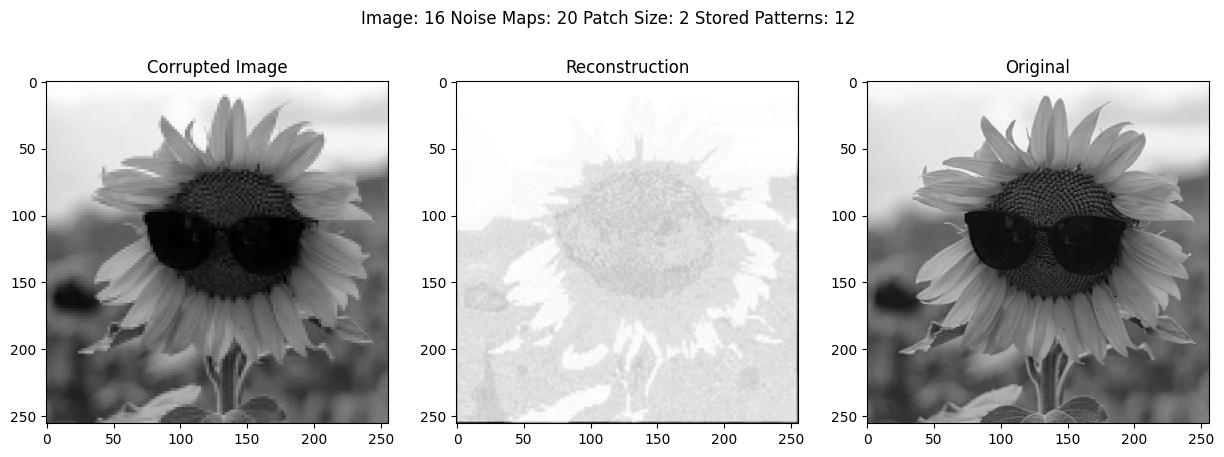

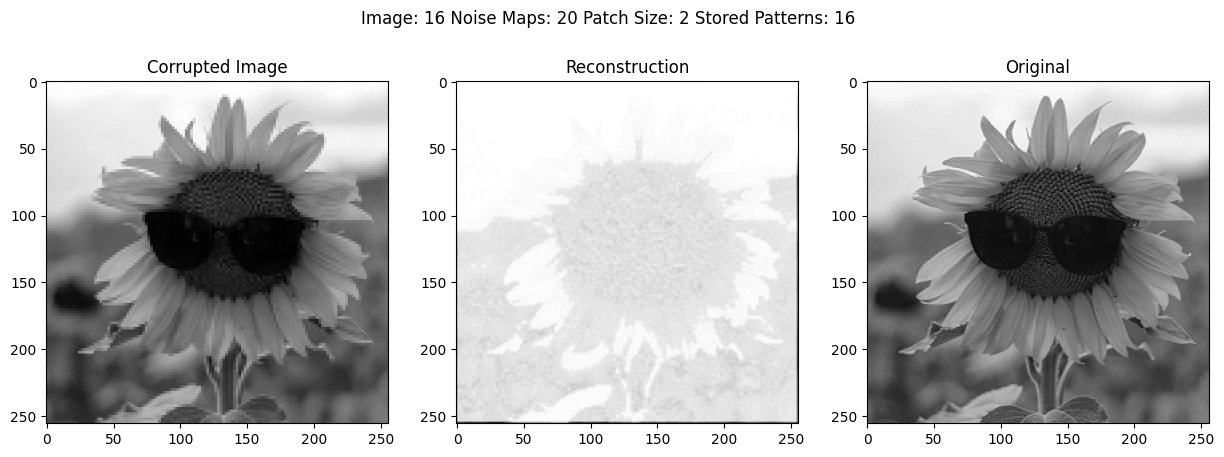

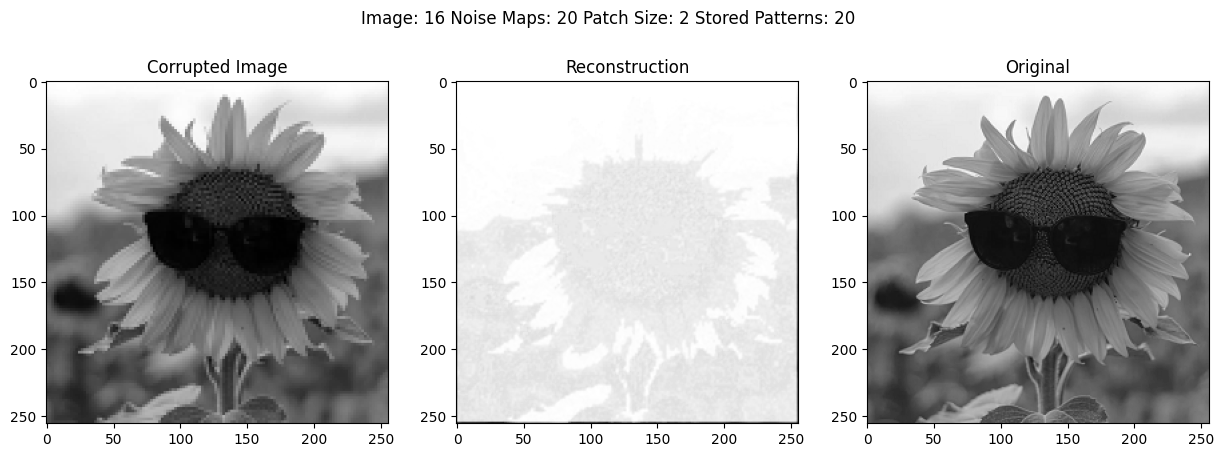

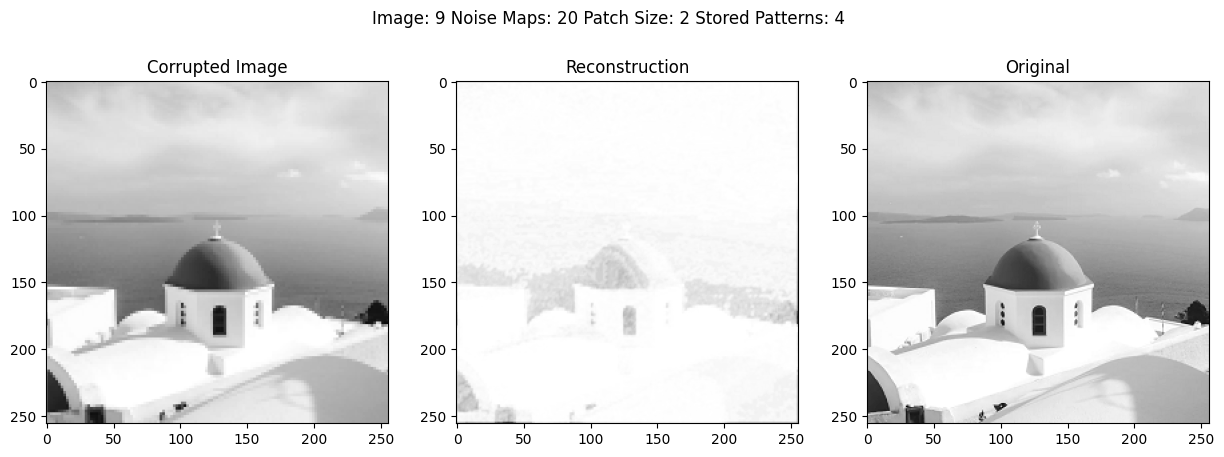

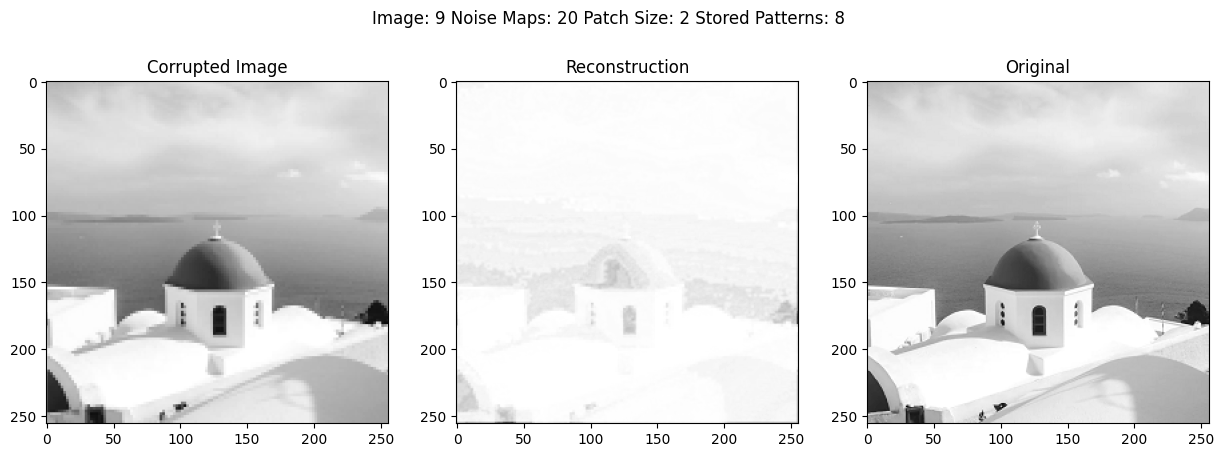

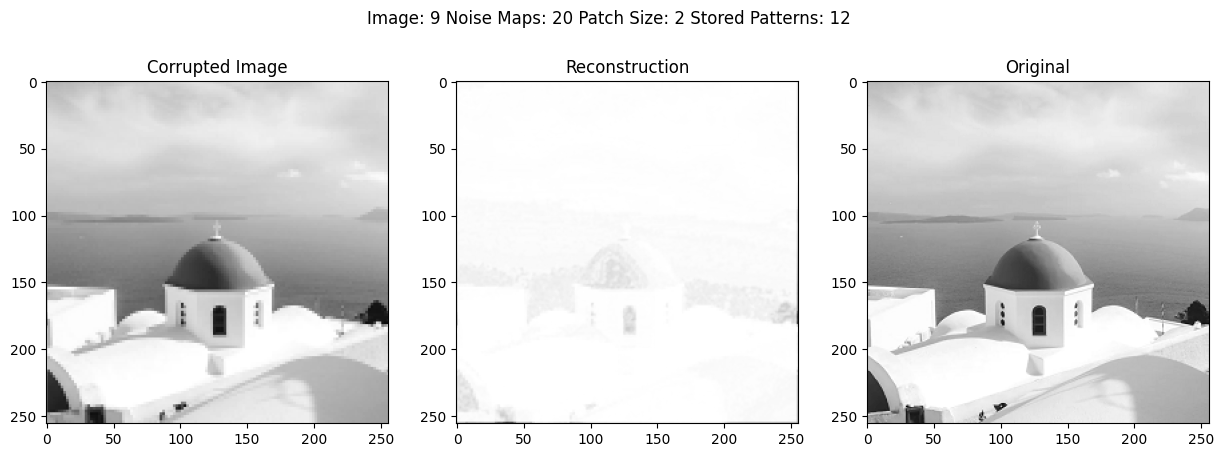

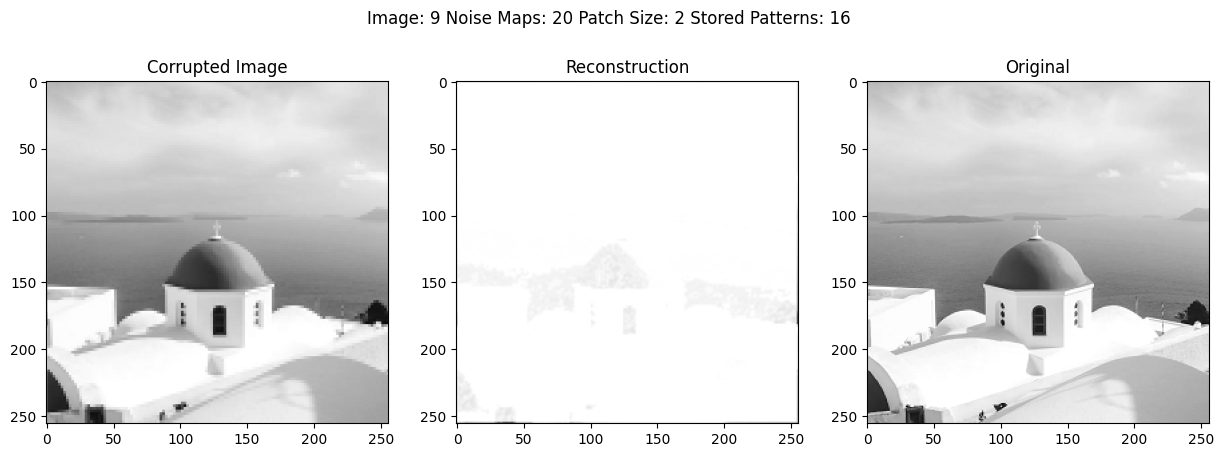

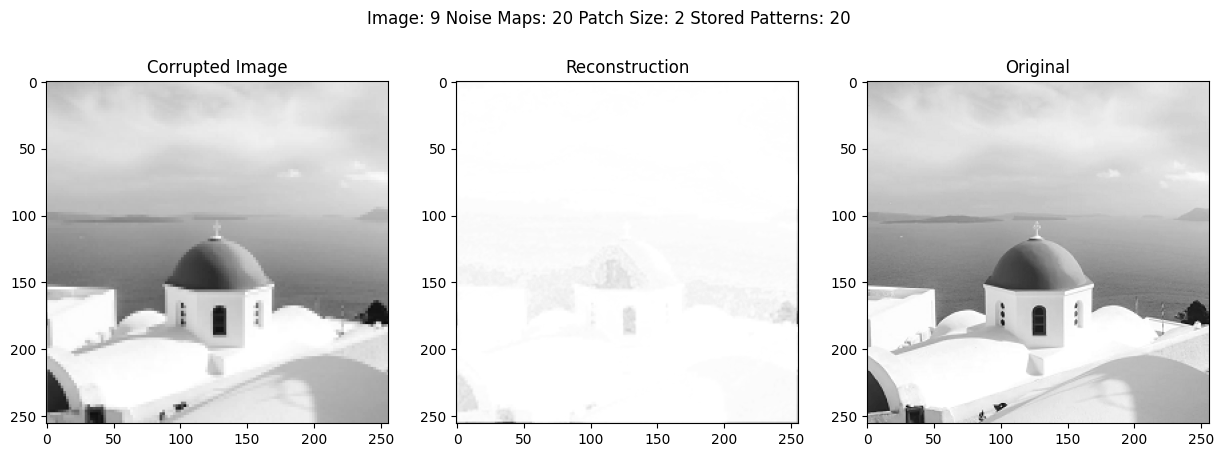

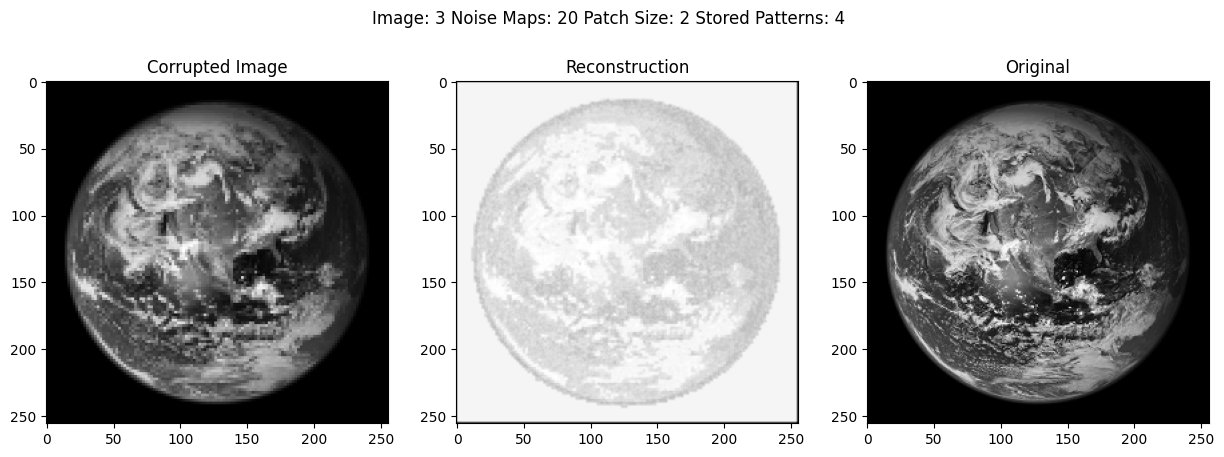

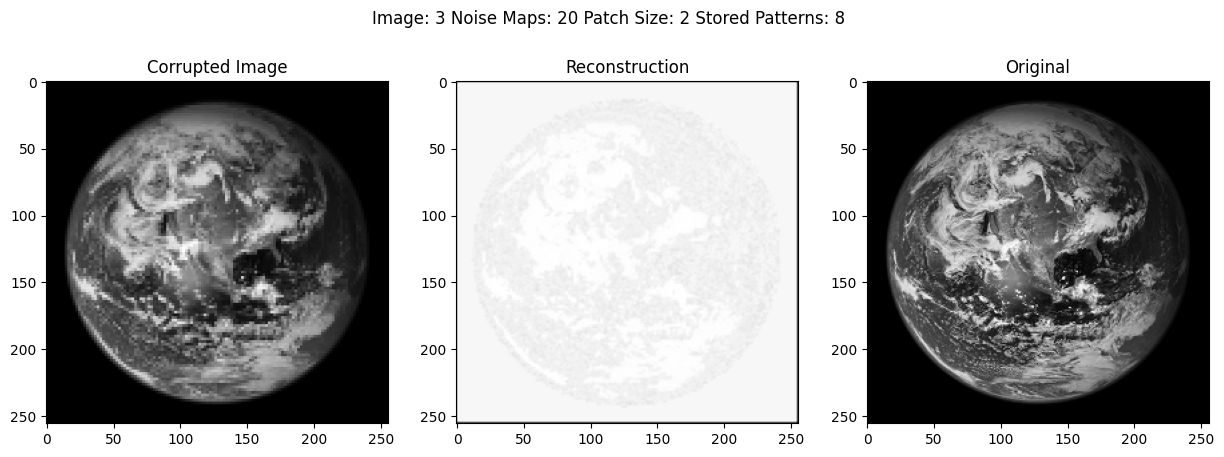

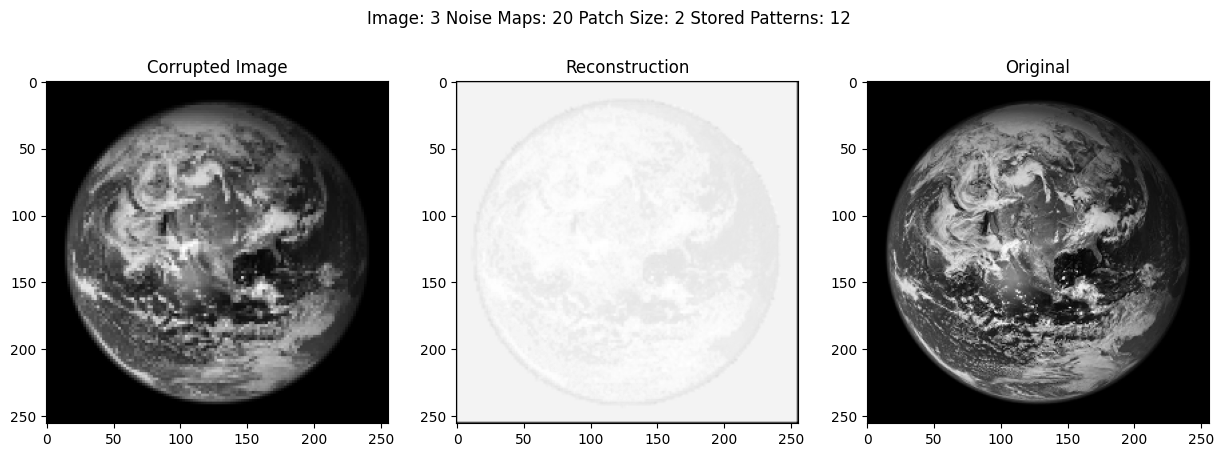

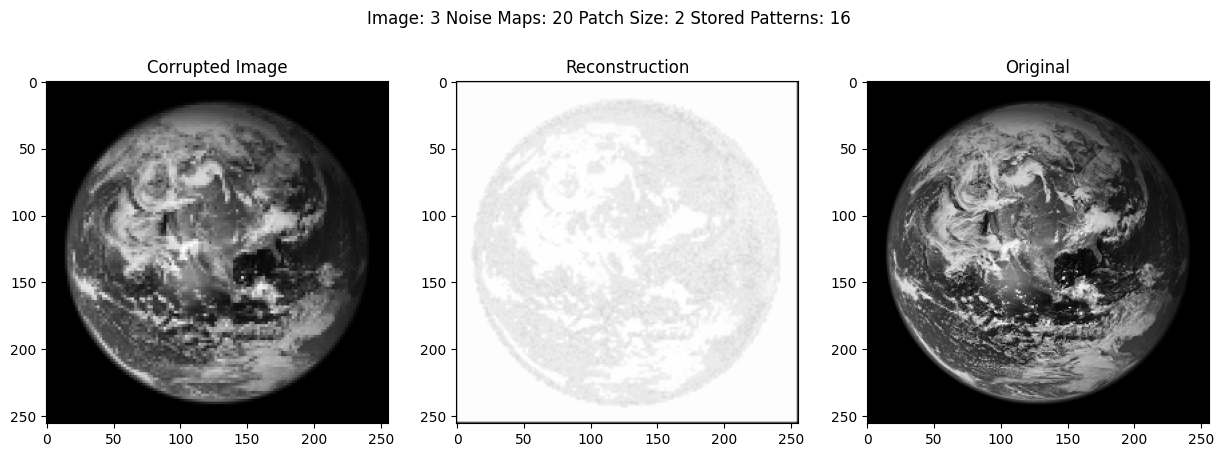

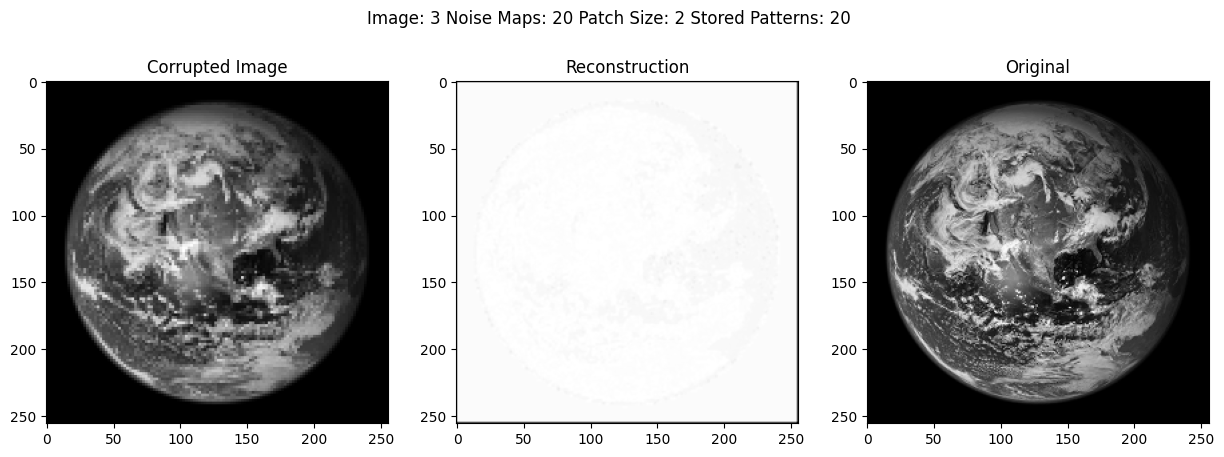

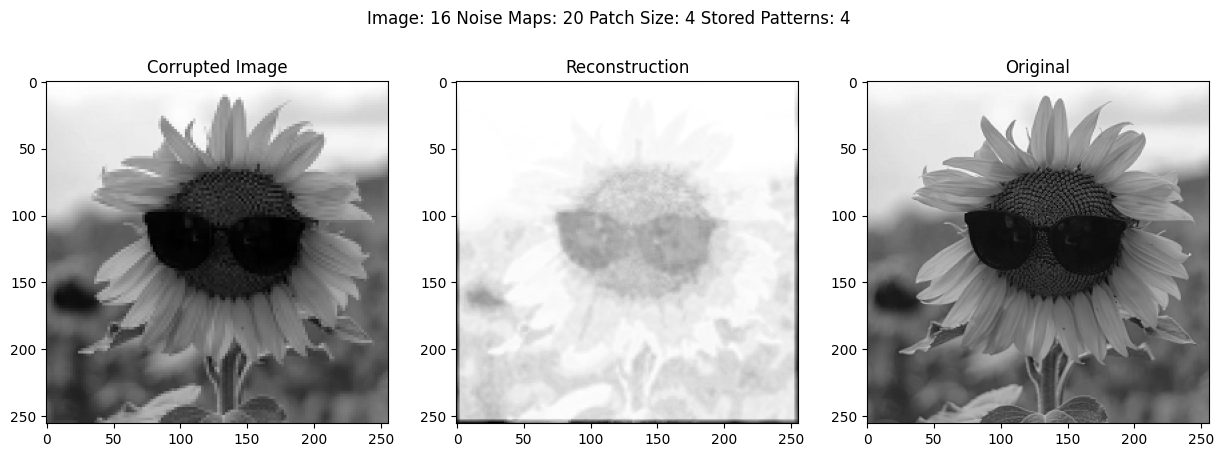

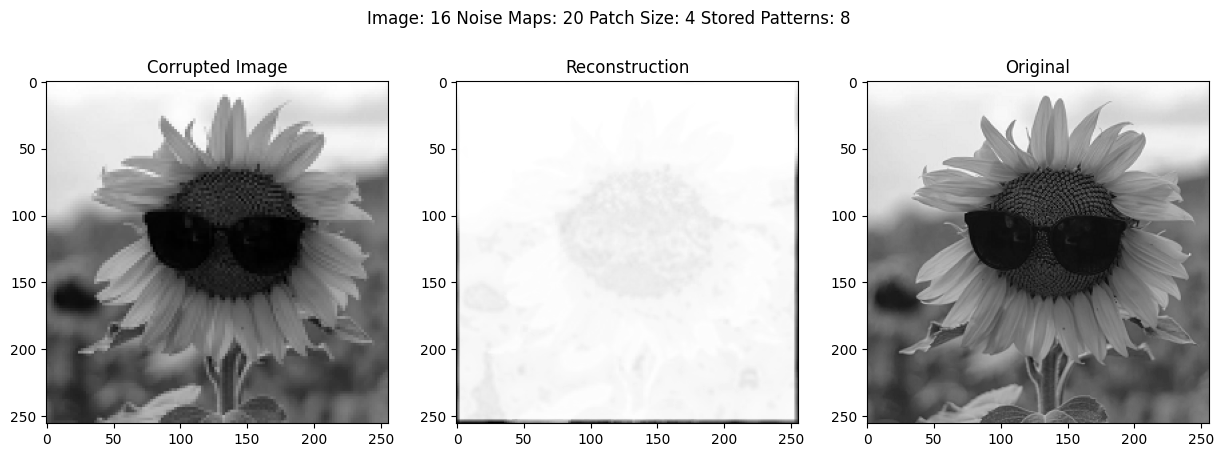

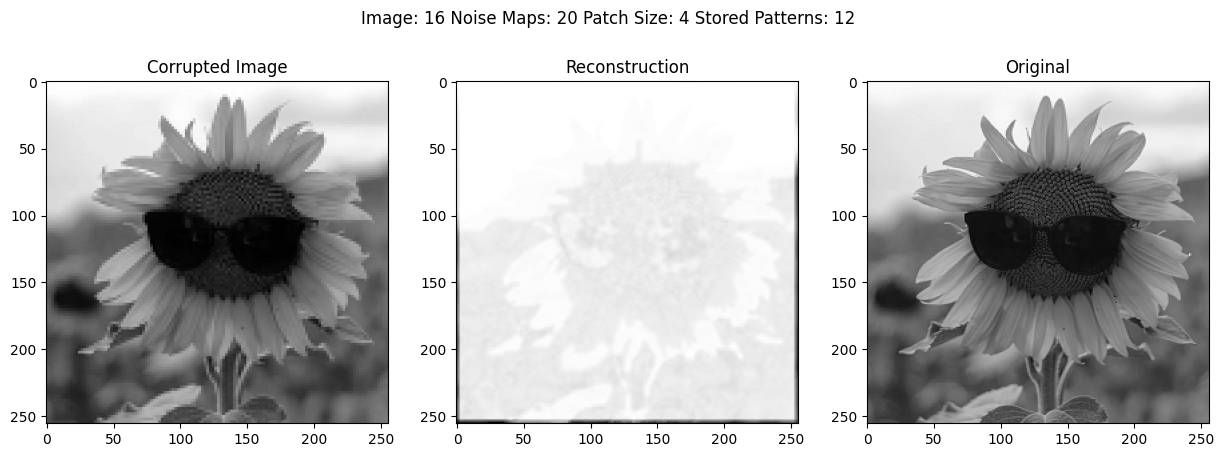

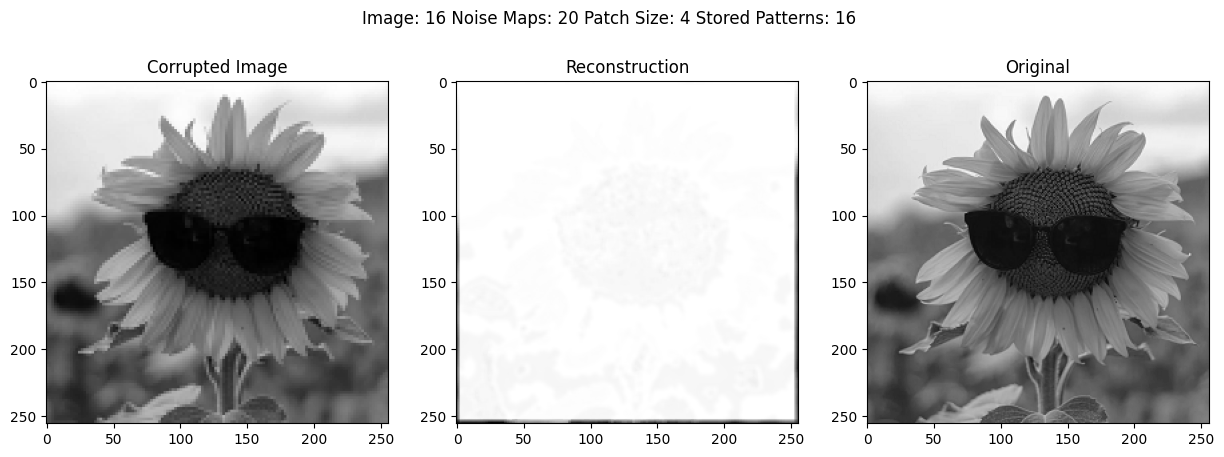

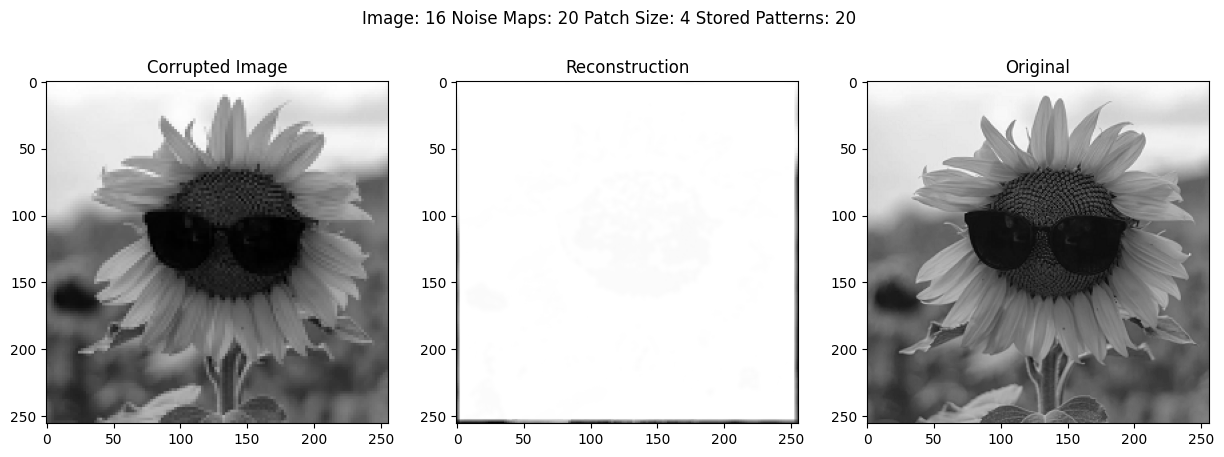

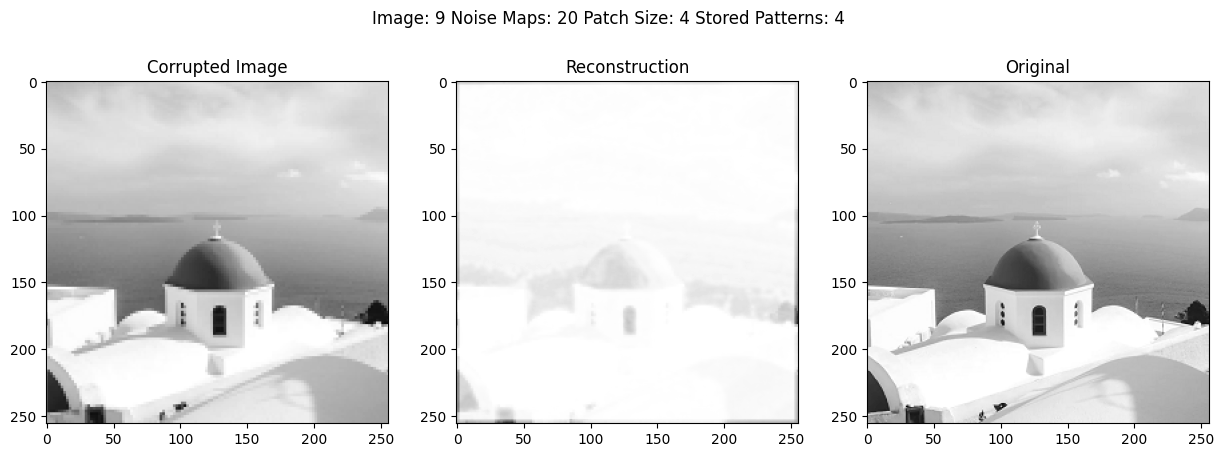

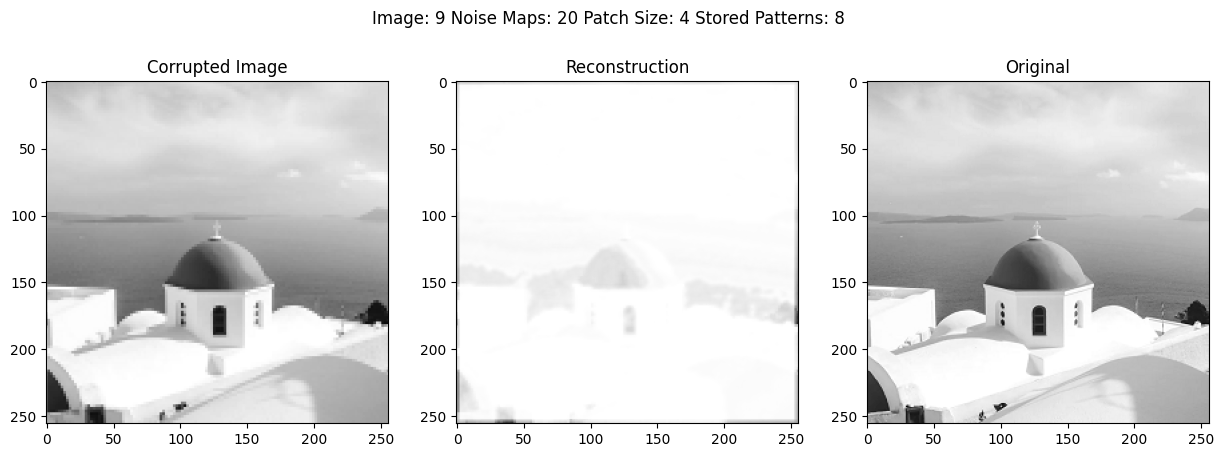

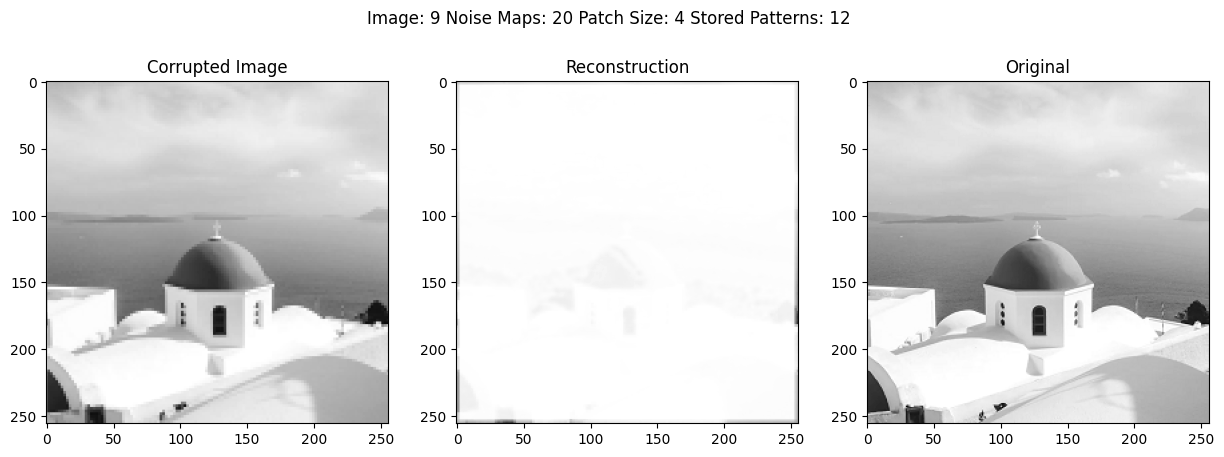

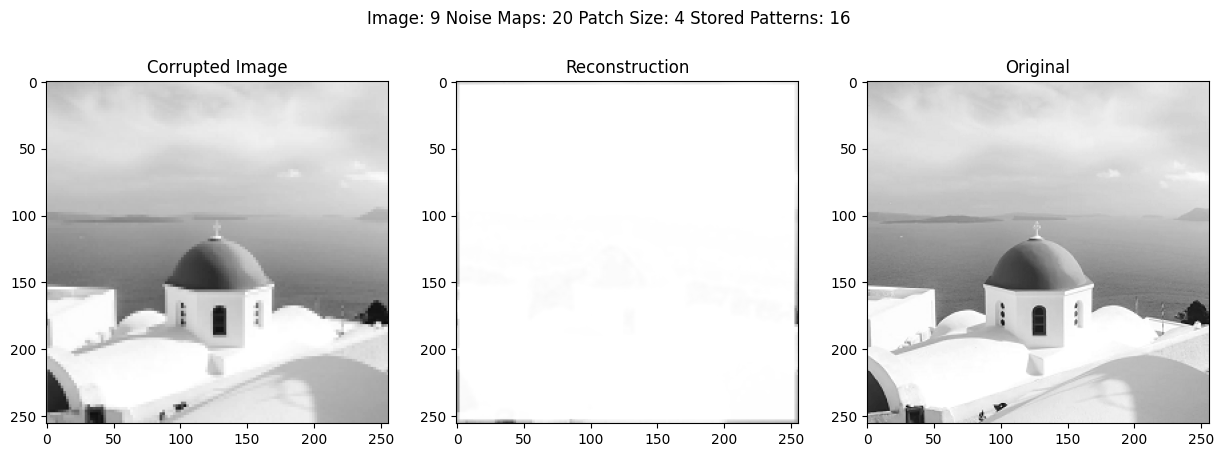

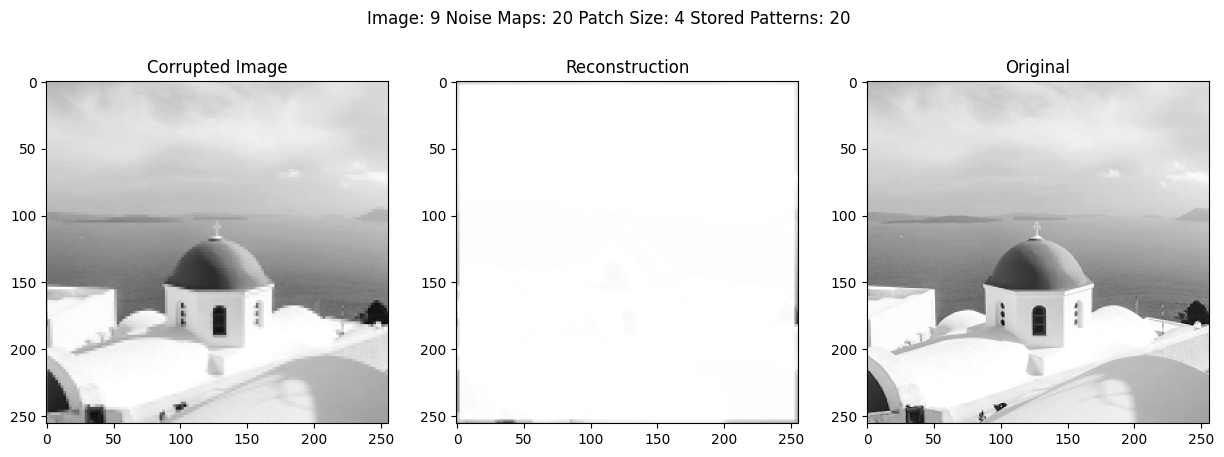

In [450]:
import matplotlib.pyplot as plt

images_folder = "./pgm images"
iterations = 20

newpath = r'output' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

for p_s in [2,4]:
    for img_num in [16,9,3]:
        fn = "128x128 expanded pgm images/expanded_128x128_image" + str(img_num) + ".pgm"   
        for n_p in range(4,21,4):
            reconstructions, t = procedure_loop_v2(iterations, images_folder, p_s, n_p, 50, fn)
            
            c = cv2.imread(fn, cv2.IMREAD_GRAYSCALE)

            a = np.mean(reconstructions, axis=0)

            normalized_a = normalize(a)
            normalized_c = normalize(c)

            reconstruction = (1 - normalized_a) * normalized_c + normalized_a

            reconstruction = reconstruction * 255

            reconstruction = np.clip(reconstruction, 0, 255)

            i_fn = "pgm images/image" + str(img_num) + ".pgm"
            original = cv2.imread(i_fn, cv2.IMREAD_GRAYSCALE)

            # cv2.imwrite("./output/img" + str(img_num) + '_' + t + ".png", reconstruction)

            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            # Display corrupted image
            axes[0].imshow(c, cmap='gray')
            axes[0].set_title('Corrupted Image')

            # Display reconstruction
            axes[1].imshow(reconstruction, cmap='gray')
            axes[1].set_title('Reconstruction')

            # Display original
            axes[2].imshow(original, cmap='gray')
            axes[2].set_title('Original')

            title = "Image: " + str(img_num) + " Noise Maps: " + str(iterations) + " Patch Size: " + str(p_s) + " Stored Patterns: " + str(n_p)
            fig.suptitle(title)

            plt.savefig("./output/img" + str(img_num) + '_' + t + '_' + "comparison" + ".png")